In [2]:
import tqdm
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
from pdf2image import convert_from_path
from IPython.display import Image
from sklearn.cluster import KMeans
import pandas as pd
from scipy.ndimage import interpolation as inter
import tqdm


C:\Users\merse\anaconda3\envs\ocr\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
cv2.THRESH_OTSU

8

439 295 781 408
1424 267 320 394


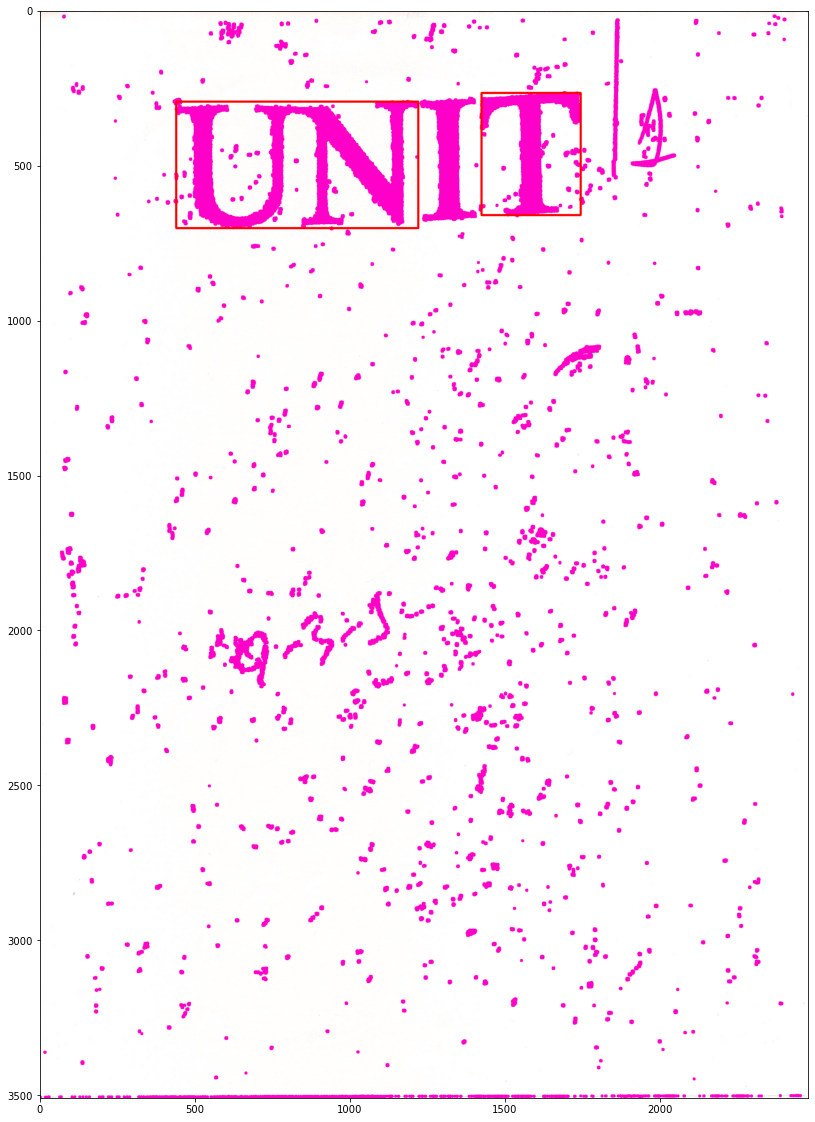

In [38]:
path_to_img = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\chapters_and_units\chu16.jpg"
#test = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\chapters_and_units\chu16.jpg"


image = cv2.imread(path_to_img)
new_image = image.copy()
#fast_denoise = cv2.fastNlMeansDenoisingColored(new_image,None,100,100,50,21)
#gray = cv2.cvtColor(fast_denoise, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 80, 255, cv2.THRESH_OTSU)

threshold = ~binary
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
with_contours = cv2.drawContours(new_image, contours, -1,(255,0,200),10)


tablature_coords = []
# Draw a bounding box around all contours
for index, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    
    # Make sure contour area is large enough
    if (cv2.contourArea(c)) > 30000:
        cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)
        tablature_coords.append({"x":x, "y":y, "w":w, "h":h})
        print(x,y,w,h)

fig = plt.figure(figsize=(20, 20))


plt.imshow(with_contours)


In [19]:
len(tablature_coords)

2

In [20]:
custom_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(900),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(saturation=0.2),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

train_path = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\chapters_and_units\train"
test_path = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\chapters_and_units\test"

Train_dataset = core.Dataset(train_path,transform = custom_transforms)#L1
Test_dataset = core.Dataset(test_path)#L2
loader = core.DataLoader(Train_dataset, batch_size = 2, shuffle=True)#L3
model = core.Model(["chapter", "unit"])#L4
losses = model.fit(loader, Test_dataset, epochs = 9, lr_step_size = 5, learning_rate = 0.0001, verbose=True)#L5

Epoch 1 of 9
Begin iterating over training dataset


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.41s/it]


Begin iterating over validation dataset


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Loss: 0.25469186156988144
Epoch 2 of 9
Begin iterating over training dataset


 38%|███████████████████████████████▌                                                    | 3/8 [00:02<00:03,  1.33it/s]


KeyboardInterrupt: 

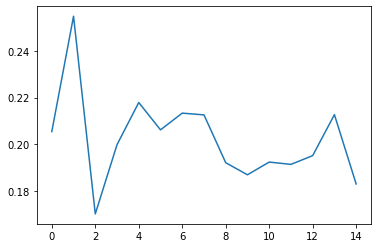

In [8]:
plt.plot(losses)
plt.show()

In [9]:
model_path = r"C:\Users\merse\Desktop\Tablature OCR\model\pagetype.pth"
model.save(model_path)

In [22]:
model_path = r"C:\Users\merse\Desktop\Tablature OCR\model\pagetype.pth"
model = core.Model.load(model_path, ["chapter", "unit"])

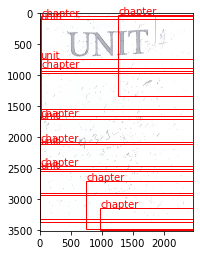

In [23]:
test = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\chapters_and_units\chu16.jpg"
image = utils.read_image(test) 
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)